In [3]:
filename = '2022_india'

In [4]:
import pandas as pd

df = pd.read_excel(f"data/{filename}.xlsx")

rows, cols = df.shape
print(f"Rows: {rows}, Columns: {cols}")

/usr/lib/python3/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Rows: 1692, Columns: 455


In [3]:
users_per_region = df.groupby('N_REGION_ISO: Region ISO 3166-2').size().reset_index(name='User Count')
print(users_per_region)

  N_REGION_ISO: Region ISO 3166-2  User Count
0                     IN-BR Bihar         241
1                     IN-DL Delhi         229
2                   IN-HR Haryana         115
3               IN-MH Maharashtra         202
4                    IN-PB Punjab         122
5                 IN-TG Telangana         210
6             IN-UP Uttar Pradesh         360
7               IN-WB West Bengal         213


In [6]:
import json

with open("data/chosen_cols.json", "r") as f:
    data = json.load(f)
    chosen_cols = [colname for colname in data["chosen_cols"] if data["chosen_cols"][colname] is True]
    persona_cols = data["persona_cols"] 

## Chosen Persona Features

In [7]:
import pandas as pd

grouped = df[persona_cols].groupby(persona_cols).size().reset_index(name='Counts')
grouped.to_csv(f"data/{filename}_persona_groups.csv", index=False)

In [10]:
grouped_cleaned = grouped[grouped["Counts"] >= 4]
grouped_cleaned.to_csv(f"data/{filename}_persona_groups_cleaned.csv", index=False)

## Chosen Columns

In [43]:
from IPython.display import display
import pandas as pd

def is_chosen_col(col):
    qsn = col.split(':')[0].strip()
    return qsn in chosen_cols

chosen_col_names = persona_cols + [col for col in df.columns if is_chosen_col(col)]
chosen = df[chosen_col_names]
chosen.to_csv(f"data/{filename}_cleaned.csv", index=False)

rows, cols = chosen.shape
print(f"Rows: {rows}, Columns: {cols}")

Rows: 1692, Columns: 178


In [44]:
len(persona_cols), len(chosen_cols)

(14, 164)

In [45]:
users_per_region = chosen.groupby('N_REGION_ISO: Region ISO 3166-2').size().reset_index(name='User Count')
print(users_per_region)

  N_REGION_ISO: Region ISO 3166-2  User Count
0                     IN-BR Bihar         241
1                     IN-DL Delhi         229
2                   IN-HR Haryana         115
3               IN-MH Maharashtra         202
4                    IN-PB Punjab         122
5                 IN-TG Telangana         210
6             IN-UP Uttar Pradesh         360
7               IN-WB West Bengal         213


## Charts

In [65]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.patches as mpatches

# Load questions JSON
with open("data/questions.json", "r") as f:
    qsns = json.load(f)

# Collect distinct option sets
option_sets = {}
for qid, qdata in qsns.items():
    opts = tuple(qdata.get("options", []))
    option_sets.setdefault(opts, []).append((qid, qdata))

print("Found", len(option_sets), "distinct option sets")

# Directory for plots
os.makedirs("plots_by_region_variation", exist_ok=True)

# Columns: only Region varies, others are fixed
fixed_cols = [
    'Q260: Sex',
    'X003R: Age recoded (6 intervals)',
    'Q275R: Highest educational level: Respondent (recoded into 3 groups)'
]

region_col = 'N_REGION_ISO: Region ISO 3166-2'

# Get all unique fixed combinations
fixed_combinations = chosen[fixed_cols].drop_duplicates()

for idx, fixed_vals in fixed_combinations.iterrows():
    # Filter df for this fixed combination
    mask = (chosen[fixed_cols] == fixed_vals.values).all(axis=1)
    subset = chosen[mask].copy()
    if subset.empty:
        continue

    # Create GroupKey: only Region varies
    subset["GroupKey"] = subset[region_col].astype(str)

    for i, (opts, qlist) in enumerate(option_sets.items(), start=1):
        option_to_num = {opt: j for j, opt in enumerate(opts)}
        heatmap_data = pd.DataFrame(index=[q[0] for q in qlist])

        for qid, qdata in qlist:
            matching_cols = [c for c in subset.columns if c.startswith(f"{qid}:")]
            if not matching_cols:
                continue
            col = matching_cols[0]

            # Group by Region only
            mode_per_group = subset.groupby("GroupKey")[col].agg(
                lambda x: x.value_counts().idxmax() if len(x.dropna()) else None
            )

            numeric_mode = mode_per_group.map(option_to_num)
            heatmap_data.loc[qid, numeric_mode.index] = numeric_mode.values

        heatmap_data = heatmap_data.dropna(how="all", axis=0).dropna(how="all", axis=1)
        if heatmap_data.empty:
            continue

        # Prepare figure
        plt.figure(figsize=(18, 8))
        ax = sns.heatmap(
            heatmap_data.astype(float),
            annot=False,
            cmap="YlGnBu",
            cbar=False
        )

        # Title with fixed column values
        fixed_desc = " | ".join([f"{col}: {val}" for col, val in zip(fixed_cols, fixed_vals)])
        plt.title(f"Most Voted Option per Question and Region\nFixed: {fixed_desc}\nOption Set {i}")
        plt.xlabel("Region")
        plt.ylabel("Question ID")
        plt.xticks(rotation=45, ha="right")

        # Legend
        cmap = plt.cm.get_cmap("YlGnBu", len(opts))
        legend_handles = [mpatches.Patch(color=cmap(j / (len(opts)-1)), label=f"{j}: {opt}")
                          for j, opt in enumerate(opts)]
        plt.legend(
            handles=legend_handles,
            title="Options",
            bbox_to_anchor=(1.05, 1),
            loc="upper left"
        )

        plt.tight_layout()
        # Save plot with fixed combination in filename
        fixed_str = "_".join([str(val).replace("/", "-") for val in fixed_vals])
        plt.savefig(f"plots_by_group/heatmap_option_set_{i}_fixed_{fixed_str}.png", dpi=300, bbox_inches="tight")
        plt.close()


Found 42 distinct option sets


/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/3831621480.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", len(opts))
/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/3831621480.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", len(opts))
/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/3831621480.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` in

Comparing Different N_REGION_ISO: Region ISO 3166-2 Options


/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/2936379874.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/2936379874.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/2936379874.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_71804/2936379874.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/nz/z1fxd0ps6vjf1nb904g0py9r0000gn/T/ipykernel_7

KeyboardInterrupt: 

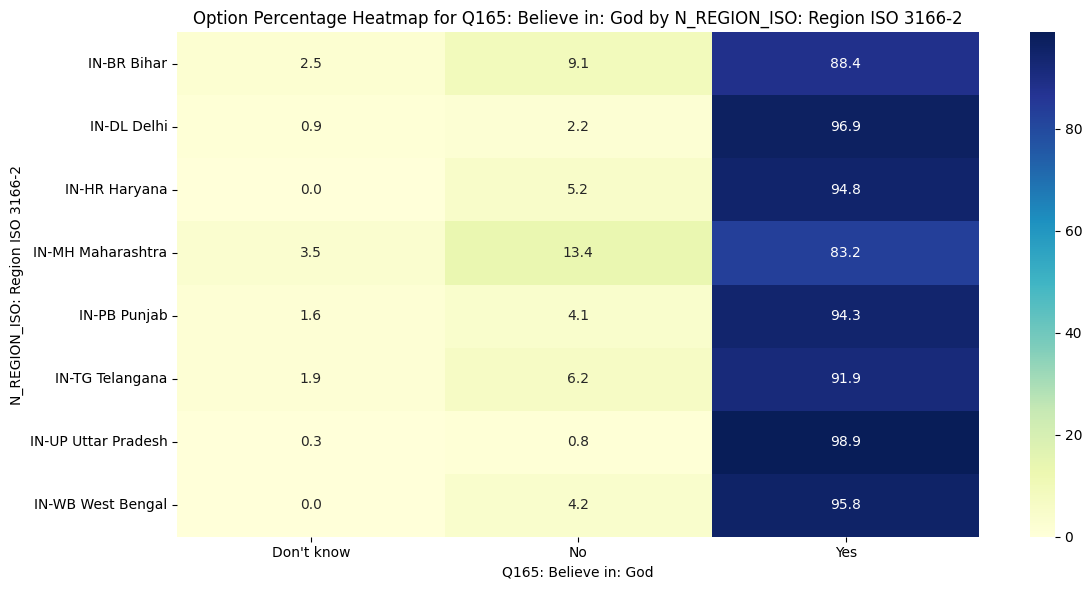

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

os.makedirs("plots3", exist_ok=True)

def sanitize_filename(name: str) -> str:
    return re.sub(r'[^A-Za-z0-9_\-]', '_', name)

cols_to_show = [col for col in chosen.columns if is_chosen_col(col)]
cols_to_compare = [
    'N_REGION_ISO: Region ISO 3166-2'
]

for persona_value in cols_to_compare:
    print(f"Comparing Different {persona_value} Options")

    for col in cols_to_show:
        if col == persona_value:
            continue

        ct = chosen.groupby(persona_value)[col].value_counts().unstack(fill_value=0)
        ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

        plt.figure(figsize=(12, 6))
        sns.heatmap(ct_pct, annot=True, fmt=".1f", cmap="YlGnBu")
        plt.title(f'Option Percentage Heatmap for {col} by {persona_value}')
        plt.xlabel(col)
        plt.ylabel(persona_value)
        plt.tight_layout()

        safe_col = sanitize_filename(col)
        safe_persona = sanitize_filename(persona_value)
        filename = f"plots3/heatmap_{safe_col}_by_{safe_persona}.png"

        plt.savefig(filename, dpi=300)
        plt.close()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

os.makedirs("plots2", exist_ok=True)

df1 = pd.read_csv("data/2022_cleaned.csv")
df1["Country"] = "India"

df2 = pd.read_csv("data/2022_russia_cleaned.csv")
df2["Country"] = "Russia"

df3 = pd.read_csv("data/2022_US_cleaned.csv")
df3["Country"] = "US"

df4 = pd.read_csv("data/2022_japan_cleaned.csv")
df4["Country"] = "Japan"

df5 = pd.read_csv("data/2022_australia_cleaned.csv")
df5["Country"] = "Australia"

df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

def sanitize_filename(name: str) -> str:
    return re.sub(r'[^A-Za-z0-9_\-]', '_', name)

cols_to_show = [col for col in df.columns if is_chosen_col(col)]
cols_to_compare = [
    'Country',
    # 'N_REGION_ISO: Region ISO 3166-2',
    # 'H_URBRURAL: Urban-Rural',
    # 'Q260: Sex',
    # 'X003R: Age recoded (6 intervals)',
    # 'Q272: Language at home',
    # 'Q273: Marital status',
    # 'Q275R: Highest educational level: Respondent (recoded into 3 groups)',
    # 'Q279: Employment status',
    # 'Q287: Social class (subjective)',
    # 'Q289: Religious denominations - major groups'
]

for persona_value in cols_to_compare:
    print(f"Comparing Different {persona_value} Options")

    for col in cols_to_show:
        if col == persona_value:
            continue

        ct = df.groupby(persona_value)[col].value_counts().unstack(fill_value=0)
        ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

        plt.figure(figsize=(12, 6))
        sns.heatmap(ct_pct, annot=True, fmt=".1f", cmap="YlGnBu")
        plt.title(f'Option Percentage Heatmap for {col} by {persona_value}')
        plt.xlabel(col)
        plt.ylabel(persona_value)
        plt.tight_layout()

        safe_col = sanitize_filename(col)
        safe_persona = sanitize_filename(persona_value)
        filename = f"plots2/heatmap_{safe_col}_by_{safe_persona}.png"

        plt.savefig(filename, dpi=300)
        plt.close()

Comparing Different Country Options
